# Student Stress Level Prediction using KNN Classification

This notebook implements a K-Nearest Neighbors (KNN) classification model to predict student stress levels based on various features. The implementation includes:

1. Data preprocessing (missing values, scaling)
2. Outlier detection
3. Dimensionality reduction using PCA
4. Model training with k-fold cross validation
5. Final model evaluation

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Initial Analysis

In [13]:
# Load the dataset
df = pd.read_csv('../dataset/StressLevelDataset.csv')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load         

## 2. Handle Missing Values

In [14]:
# Handle missing values by filling them with median values
for column in df.columns:
    if df[column].isnull().any():
        df[column].fillna(df[column].median(), inplace=True)

print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64


## 3. Outlier Detection

Number of outliers in each column:
anxiety_level: 0 outliers
self_esteem: 0 outliers
mental_health_history: 0 outliers
depression: 0 outliers
headache: 0 outliers
blood_pressure: 0 outliers
sleep_quality: 0 outliers
breathing_problem: 0 outliers
noise_level: 173 outliers
living_conditions: 62 outliers
safety: 0 outliers
basic_needs: 0 outliers
academic_performance: 0 outliers
study_load: 165 outliers
teacher_student_relationship: 0 outliers
future_career_concerns: 0 outliers
social_support: 0 outliers
peer_pressure: 0 outliers
extracurricular_activities: 0 outliers
bullying: 0 outliers
stress_level: 0 outliers


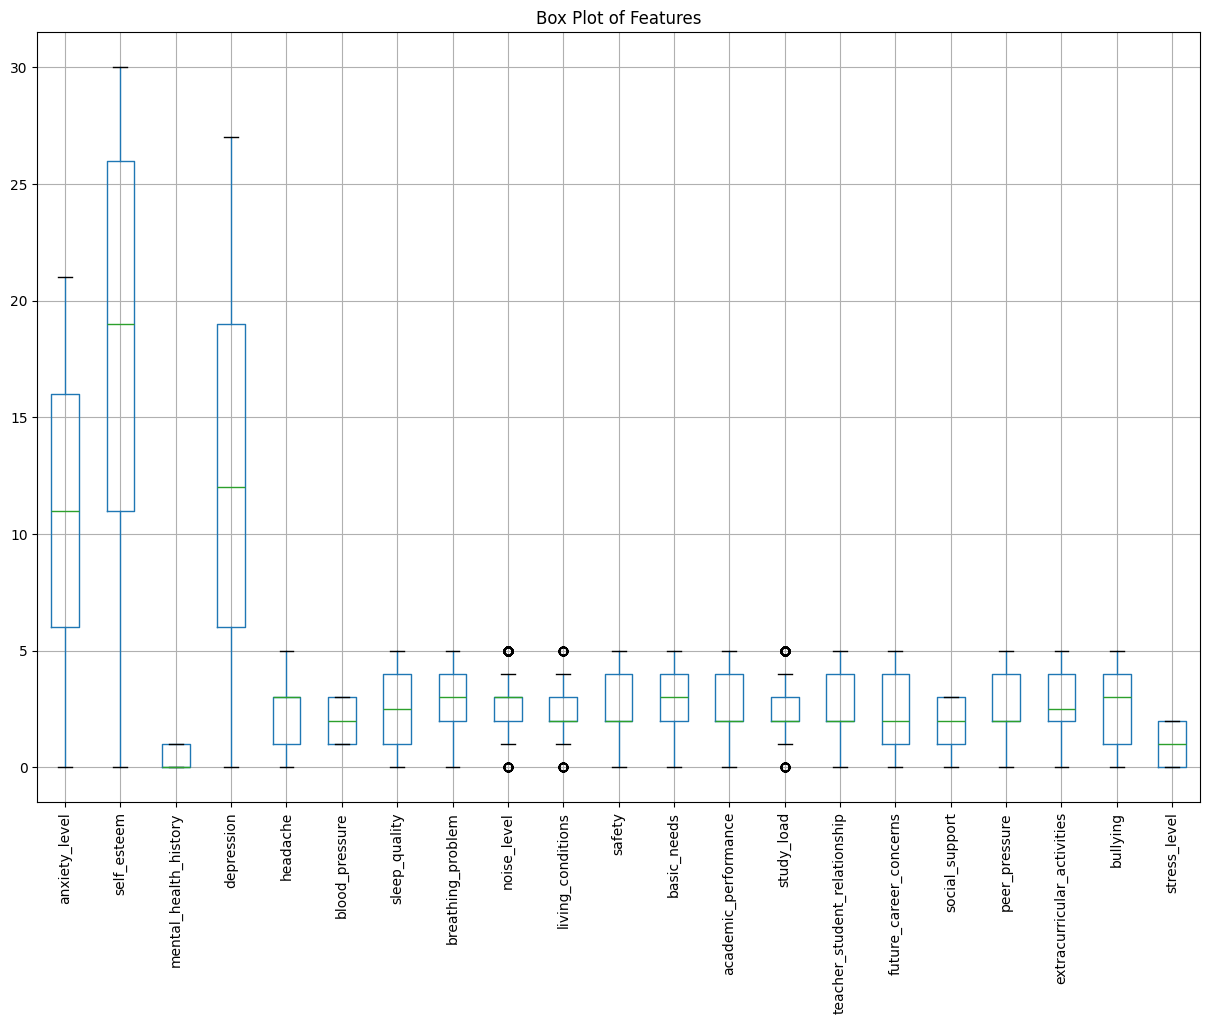

In [15]:
# Function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

# Check for outliers in numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Number of outliers in each column:")
for column in numerical_columns:
    n_outliers = detect_outliers(df, column)
    print(f"{column}: {n_outliers} outliers")

# Create box plots to visualize outliers
plt.figure(figsize=(15, 10))
df.boxplot()
plt.xticks(rotation=90)
plt.title("Box Plot of Features")
plt.show()

# Handle outliers by capping them at the IQR boundaries
for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

## 4. Feature Scaling

In [16]:
# Separate features and target
X = df.drop('stress_level', axis=1)
y = df['stress_level']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## 5. Dimensionality Reduction (PCA)

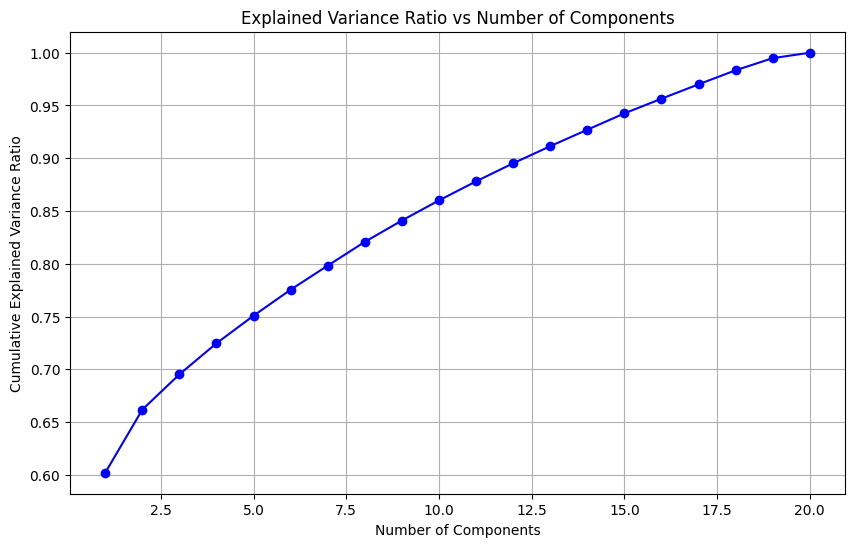

Number of components needed for 95% variance: 16

Shape of data after PCA: (1100, 16)

Explained variance ratio for each component:
Component 1: 0.6020
Component 2: 0.0598
Component 3: 0.0334
Component 4: 0.0295
Component 5: 0.0261
Component 6: 0.0247
Component 7: 0.0228
Component 8: 0.0225
Component 9: 0.0202
Component 10: 0.0191
Component 11: 0.0180
Component 12: 0.0171
Component 13: 0.0162
Component 14: 0.0156
Component 15: 0.0155
Component 16: 0.0139


In [17]:
# Apply PCA
# First, let's find the optimal number of components that explain 95% of variance
pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.show()

# Find number of components needed for 95% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
print(f"\nShape of data after PCA: {X_pca.shape}")
print("\nExplained variance ratio for each component:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.4f}")

## 6. Model Training with K-fold Cross Validation

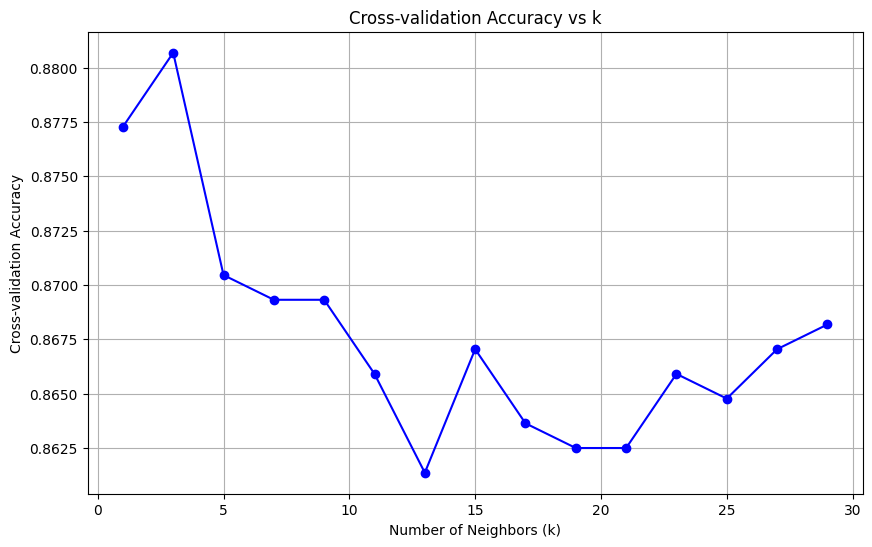

Optimal k value: 3
Best cross-validation accuracy: 0.8807


In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Find optimal k using k-fold cross validation
k_values = list(range(1, 31, 2))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, 'bo-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validation Accuracy')
plt.title('Cross-validation Accuracy vs k')
plt.grid(True)
plt.show()

# Find the optimal k value
optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal k value: {optimal_k}")
print(f"Best cross-validation accuracy: {max(cv_scores):.4f}")

## 7. Final Model Evaluation

Model Evaluation Metrics:

Accuracy Score:
0.8545454545454545

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        76
           1       0.87      0.85      0.86        73
           2       0.88      0.83      0.86        71

    accuracy                           0.85       220
   macro avg       0.86      0.85      0.85       220
weighted avg       0.86      0.85      0.85       220



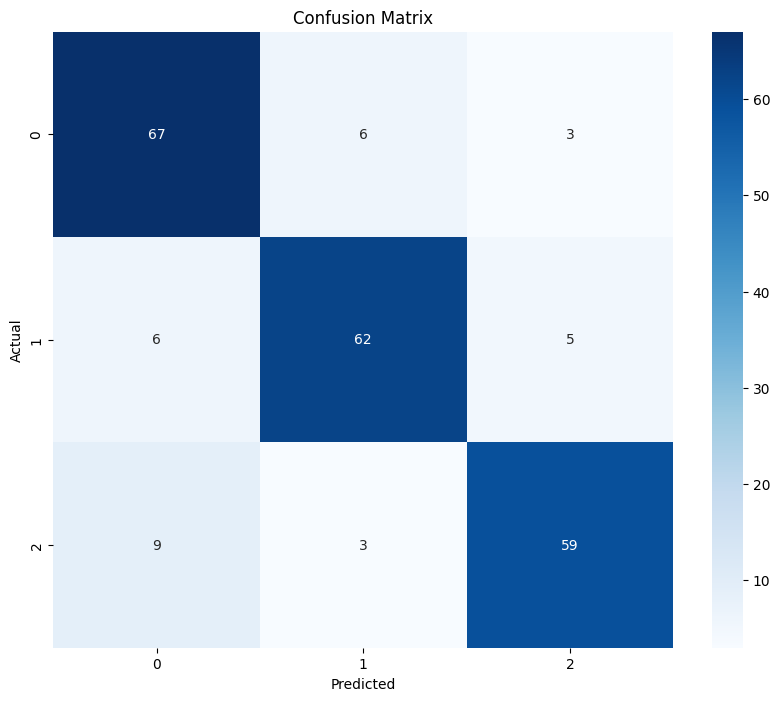

In [19]:
# Train the final model with optimal k
final_model = KNeighborsClassifier(n_neighbors=optimal_k, metric='euclidean')
final_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = final_model.predict(X_test)

# Print model evaluation metrics
print("Model Evaluation Metrics:")
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()